## Summary

Created: 10/20/2017 (cloned from part2_analysis_wasp21)

Last edit: 10/20

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
#import multiprocessing

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

In [4]:
import getpass
from tqdm import tqdm

data_dir = '.'
file_list=glob.glob(data_dir+'/*.csv')
file_list.sort()
len(file_list)

3

## import lc

In [5]:
data={}
bands='g,r,z'.split(',')

for i,(f,b) in enumerate(zip(file_list,bands)):
    df=pd.read_csv(os.path.join(data_dir,f), delimiter=',', parse_dates=True)
    #df.columns='GJD,GJD-2450000,flux,err,airmass,sky,dx,dy'.split(',')
    #df = df.set_index('BJD(TDB)-2450000')
    #df = df.set_index('GJD-2450000')
    df = df.set_index('GJD')
    data[b]=df

In [6]:
data[b].head()

,GJD-2450000,flux,err,airmass,sky,dx,dy
GJD,,,,,,,
2.457873e+06,7873.125249,1.002693,0.001688,1.0168,204.5,4.071,18.302
2.457873e+06,7873.125874,1.005096,0.001696,1.0171,204.5,3.827,18.789
2.457873e+06,7873.126499,1.003830,0.001694,1.0174,205.3,3.788,19.184
2.457873e+06,7873.127135,1.004984,0.001695,1.0177,206.3,3.310,19.632
2.457873e+06,7873.127760,1.001326,0.001692,1.0180,206.6,3.489,20.148


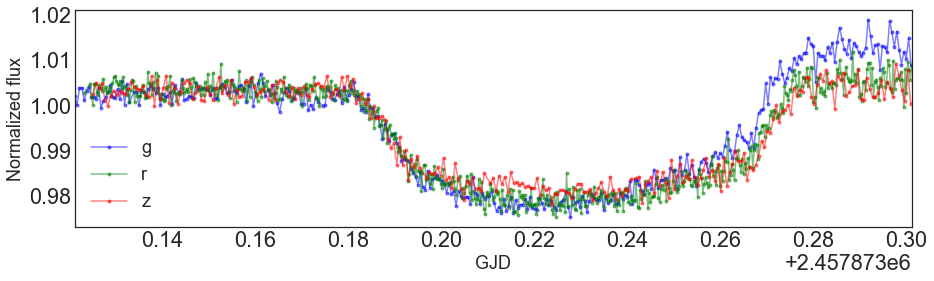

In [7]:
colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for (b,c) in zip(sorted(bands),colors):
    df = data[b]
    df.flux.plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    ax.set_ylabel('Normalized flux')
pl.legend()

## building the model

* See [exoplanet.org](http://exoplanets.org/detail/WASP-21_b) for published transit parameters

In [8]:
from uncertainties import ufloat 

P   = ufloat(3.2130598,2.1e-6)
Rp  = ufloat(0.959,0.029)
#tc  = ufloat(2454400.19885, 0.0002) 
t14 = ufloat(0.09740,0.0006) 
b   = ufloat(0.211,0.07)     
a_s = ufloat(11.80,0.31)   
k   = ufloat(np.sqrt(0.01977),np.sqrt(0.000183)) 
rhop= ufloat(0.295,0.025)
inc = ufloat(89.00,0.4)

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [9]:
_P   = 3.2130598
#_tc  = 245778e6+8.01
_t14 = 0.09740
_b   = 0.211
_a_s = 11.80
_k   = np.sqrt(0.01977)
_inc = np.deg2rad(89.00)

def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

a_s_=scaled_a(_P, _t14, _k, i=_inc, impact_param=_b)
a_s_

11.789821867071863

In [10]:
inc_ = np.arccos(_b/a_s_)
np.rad2deg(inc_)

88.974534554473834

In [11]:
from pytransit import MandelAgol
MA = MandelAgol()

def q_to_u(q1, q2):
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    MA = MandelAgol()
    k,tc,a,b,q1,q2 = theta[:6]
    inc   = np.arccos(b/a)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

In [18]:
tc_0  = 2.457873e6+0.23
q1_0, q2_0 = 0.4, 0.4

theta_true= [_k,tc_0,_a_s, _b, q1_0, q2_0]

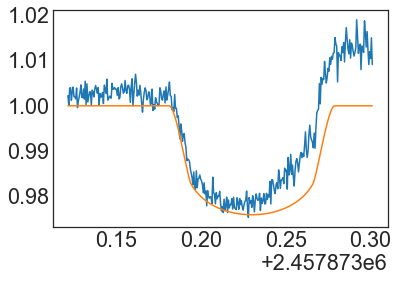

In [19]:
b='g'
f=data[b].flux
t=data[b].index

m=model_q(theta_true, t, _P)

pl.plot(data[b].index,f)
pl.plot(t,m)

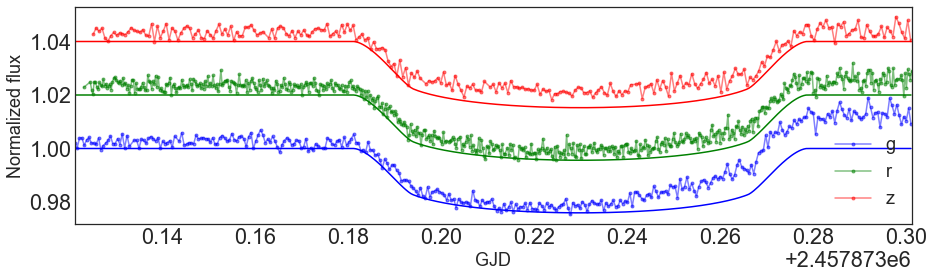

In [20]:
theta_vec = []

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for i,(b,c) in enumerate(zip(sorted(bands),colors)):
    df = data[b]
    df.flux.apply(lambda x: x+0.02*i).plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    #compute model
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    m=model_q(theta, t, _P)
    ax.plot(t,m+0.02*i,color=c)
    ax.set_ylabel('Normalized flux')
    theta_vec.append(theta)
pl.legend()

In [21]:
import scipy.optimize as op

def obj(theta, t, f, p):
    '''
    objective function is ordinary least squares
    c.f. chi-quared which includes point-wise sigma
    '''
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

In [22]:
ts = [data[b].index for b in sorted(bands)]
fluxes = [data[b]['flux'] for b in bands]

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [23]:
import scipy.optimize as op

def obj(theta, t, f, p):
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

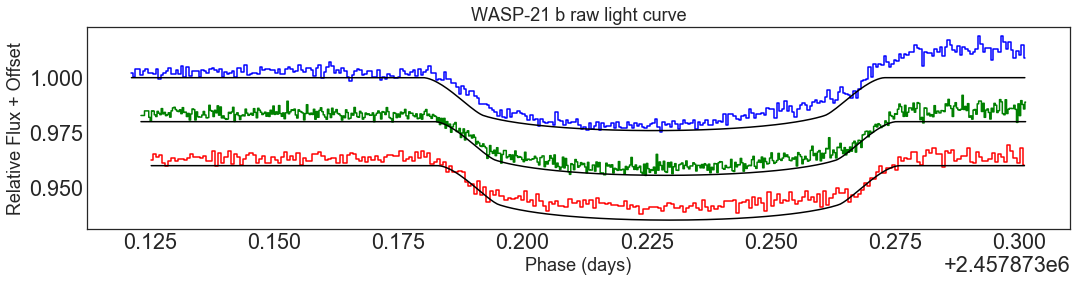

In [24]:
fontsize=18

ts,fluxes=[],[]
airmasses,uncs,dxs,dys=[],[],[],[]

colors='b,g,r'.split(',')

fig, axs = pl.subplots(1,1, figsize=(15,4), sharey=True)
for i,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)    
    f=d['flux']
    t=f.index
    
    ts.append(t)
    fluxes.append(f)
    
    axs.plot(t,f-0.02*i, drawstyle='steps-mid', c=colors[i])
    res = op.minimize(obj, theta_vec[i], args=(t, f, _P), method='nelder-mead')
    model = model_q(res.x, t, _P)
    axs.plot(t, model-0.02*i, 'k-');
    
    fig.tight_layout()

    #sys mod params
    airmasses.append(d['airmass'])
    uncs.append(d['err'].values)
    #peak_fluxes.append(d['peak'].values)
    #fwhms.append(d['fwhm'].values)
    dxs.append(d['dx'].values)
    dys.append(d['dy'].values)
    
axs.set_title('WASP-21 b raw light curve',fontsize=fontsize)
axs.set_ylabel('Relative Flux + Offset',fontsize=fontsize)
axs.set_xlabel('Phase (days)',fontsize=fontsize)

In [25]:
#systematics model (time-dependent)
def model_s(theta, aux_vec, t):
    airmass, xcenter, ycenter = aux_vec
    #functional form of systematics model
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[airmass, xcenter, ycenter, offset, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, aux_vec, ret_mod=False, ret_sys=False, ret_full = False):
    #airmass, xcenter, ycenter = aux_vec
    ls = theta[6]
    m = model_q(theta[:6], t, p)
    s = model_s(theta[7:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

--g--
NLL before: -1481.6853992233953
NLL after: -1533.4009650054857
residual: std=0.0039, rms=0.0068
--r--
NLL before: -2748.8809164331806
NLL after: -2857.1218436877652
residual: std=0.0020, rms=0.0048
--z--
NLL before: -1239.7568530720469
NLL after: -1293.743248704906
residual: std=0.0023, rms=0.0036


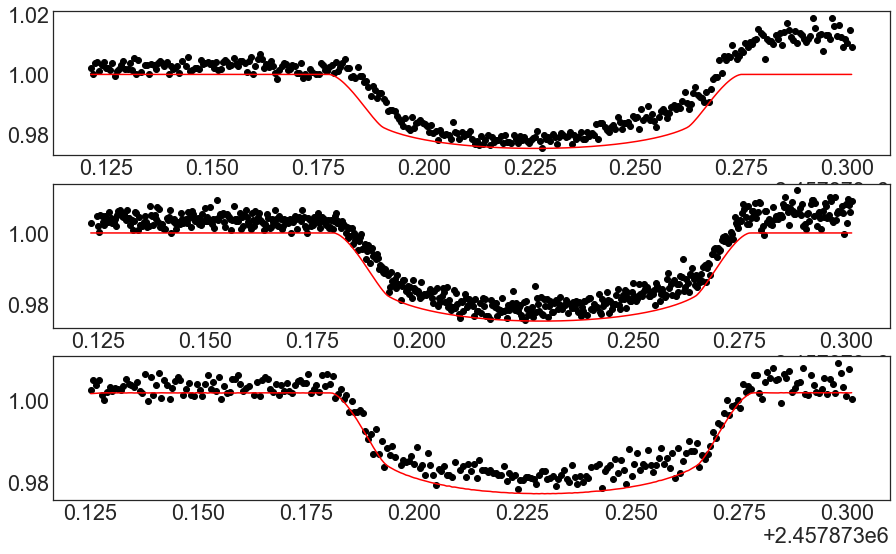

In [26]:
#systematics parameters
k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [0]*10
#log flux uncertainty
k_list= [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]
nparams=5
ip = 0 #impact param, b
#parameters vector: 6 free, 7 input

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

for n,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)
    #remove outliers
    #d=d[np.abs(d-d.mean())<=(3*d.std())]

    f=d['flux']
    t=f.index

    #sys mod params
    airmass = d['airmass'].values
    err=d['err'].values
    #peak_flux=d['peak(ADU)'].values
    #fwhm = d['fwhm(pix)'].values
    dx = d['dx'].values
    dy = d['dy'].values
    print('--{}--'.format(b))
    
    #parameters vector: 6 free, 3 input
    ls = np.log(np.nanstd(f))
    
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta_sys = np.concatenate((theta, [ls], k_list[:nparams]))
    
    aux_vec = (airmass, dx, dy)
    print ("NLL before: {}".format(nll(theta_sys, t, f, _P, aux_vec)))
    result = op.minimize(nll, theta_sys,    args=(t, f, _P, aux_vec), 
                         method='nelder-mead')
    print ("NLL after: {}".format(nll(result.x,   t, f, _P, aux_vec)))

    f_pred = loglike(result.x, t, f, _P, aux_vec, ret_full=True)
    mod    = loglike(result.x, t, f, _P, aux_vec, ret_mod=True)
    sys    = loglike(result.x, t, f, _P, aux_vec, ret_sys=True)
    resid=f-f_pred
    sigma=np.std(resid)
    rms=np.sqrt(np.mean(resid**2))
    print('residual: std={0:.4f}, rms={1:.4f}'.format(sigma, rms))
    
    ax = pl.subplot(3,1,n+1)
    ax.plot(t, f, 'ko', t, f_pred, 'r-');

## Limb-darkening prior
```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [27]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=6100,65,4.190,0.03, -0.200, 0.06

#limbdark priors
ldp = []
for i in 'g*,r*,z*'.split(','):
    ldp.append(lb.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4)))

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

In [28]:
theta

[0.14260583202698243, 2457873.23, 11.811226632004658, 0.211, 0.4, 0.4]

In [29]:
from scipy import stats
def logprior(theta,up=None):
    k,tc,a,impact_param,q1,q2 = theta[:6]
    inc=np.arccos(impact_param/a)
    
    
    #or k from 0 up to order of max_k (Seager paper)?
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > 1 or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a   < 0 or a  > 100 or \
        tc < t[0] or tc > t[-1]:
            
        print('off limits encountered in logprior')
        return -np.inf

    lp = 0
    #u prior
    u1,u2 = q_to_u(q1,q2)
    
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    
    return lp

def logprob(theta_sys,ts,fluxes,p,airmasses,dxs,dys,up=None):
    t1,t2,t3 = ts
    f1,f2,f3 = fluxes
    airmass1,airmass2,airmass3 = airmasses
    xcen1,xcen2,xcen3 = dxs
    ycen1,ycen2,ycen3 = dys
    k1,k2,k3,tc,a1,a2,a3,impact_param,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,\
    k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta_sys
    
    theta1 = [k1,tc,a1,impact_param,q11,q21,ls1,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a2,impact_param,q12,q22,ls2,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a3,impact_param,q13,q23,ls3,k03,k13,k23,k33,k43]
    
    aux_vec1 = airmass1, xcen1, ycen1
    aux_vec2 = airmass2, xcen2, ycen2
    aux_vec3 = airmass3, xcen3, ycen3
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, f1, p, aux_vec1)
    ll += loglike(theta2, t2, f2, p, aux_vec2)
    ll += loglike(theta3, t3, f3, p, aux_vec3)
    
    if up is not None:
        lp  = logprior(theta1,up=up[0])
        lp += logprior(theta2,up=up[1])
        lp += logprior(theta3,up=up[2])
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

sanity check

In [30]:
theta_vec=[]
for i,j in enumerate(bands):
    #a.append(scaled_a(p_, t14_, k_, inc=np.pi/2))
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta.append(theta_vec)

k1,k2,k3     = [_k+0.001,_k+0.002,_k+0.002]  
q11,q12, q13 = [0.4] * 3
q21,q22, q23 = [0.4] * 3
a1,a2,a3     = [a_s_]* 3

#systematics parameters
k01, k11, k21, k31, k41 = [0] * 5
k02, k12, k22, k32, k42 = [0] * 5
k03, k13, k23, k33, k43 = [0] * 5


#log flux uncertainty
ls1,ls2,ls3 = [np.log(np.nanstd(f)) for f in fluxes]  
t1,t2,t3         = ts
f1,f2,f3         = fluxes
xcen1,xcen2,xcen3= dxs
ycen1,ycen2,ycen3= dys
airmass1,airmass2,airmass3=airmasses
#fwhm1,fwhm2,fwhm3= fwhms
#unc1,unc2,unc3   = uncs

In [31]:
theta_sys = [k1,k2,k3,tc_0,a1,a2,a3,_b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]
args = [ts,fluxes,_P,airmasses,dxs,dys]

In [32]:
#without ldp
logprob(theta_sys, *args)

5472.0299894639738

In [33]:
#with ldp
logprob(theta_sys, *args, up=ldp)

5132.4225419223621

In [ ]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

ndim = len(theta_sys)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

sampler = EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

#random initial condition
pos0 = sample_ball(theta_sys, [1e-4]*ndim, nwalkers)
'''pos0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in xrange(nwalkers)]'''

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

563it [26:28,  1.83s/it]

## Initial results: Parameter best estimates (including burn-in)

In [24]:
#save gzip

chain=sampler.chain
import gzip
loc='/home/jp/data/transit/hatp44_data/MCMC/'
with gzip.GzipFile(os.path.join(loc,'best_model_1.npy.gz'), "w") as g:
    np.save(g, chain)
#np.allclose(sample_chain.shape,chain.shape)

In [21]:
import gzip
#load gzip
loc='/home/jp/data/transit/hatp44_data/MCMC/'
#with gzip.GzipFile(os.path.join(loc,'best_model_1.npy.gz'), "r") as g:
with gzip.GzipFile(os.path.join(loc,'best_model_long_chain1.npy.gz'), "r") as g:
    chain=np.load(g)

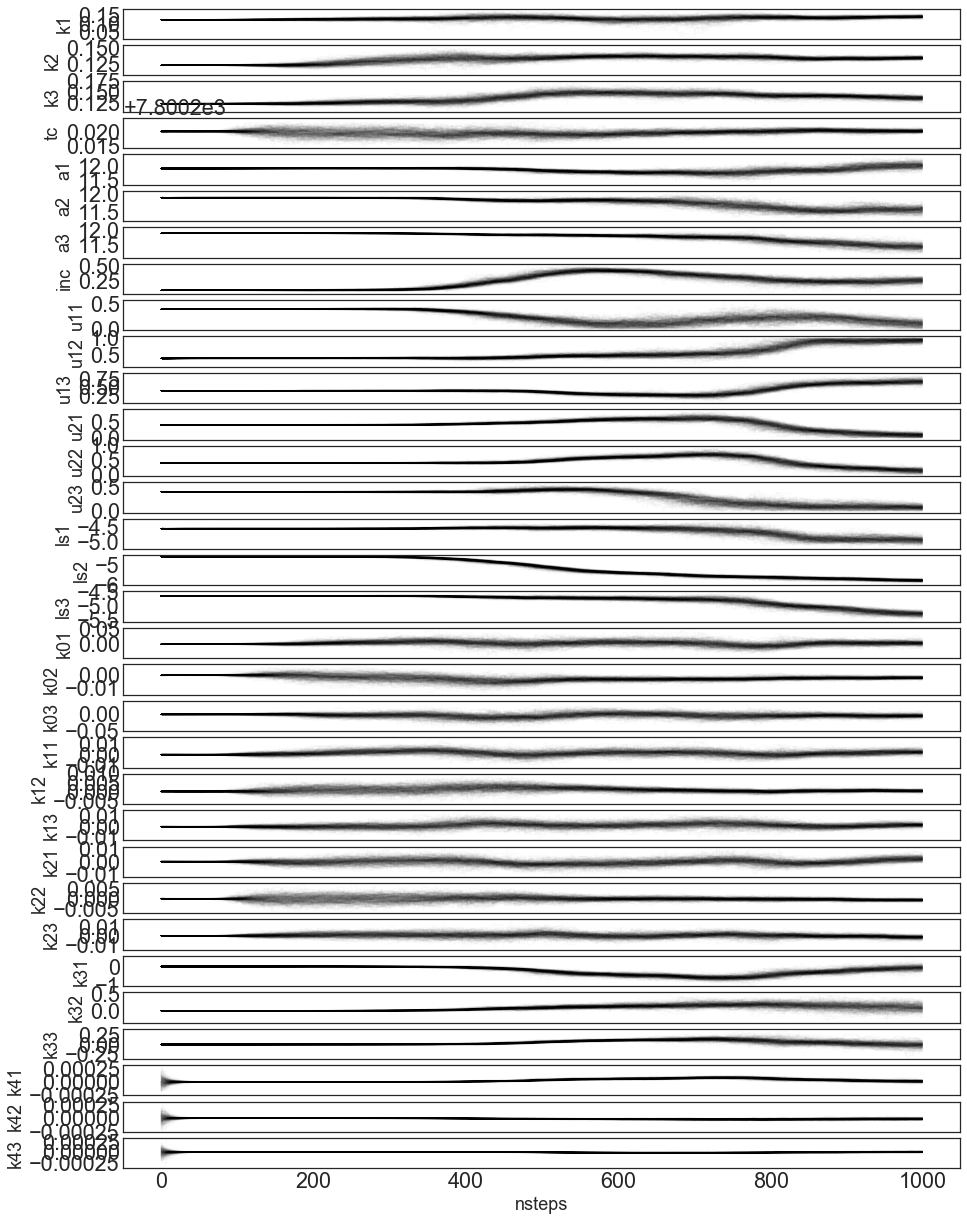

In [25]:
plt.style.use('seaborn-white')

param_names='k1,k2,k3,tc,a1,a2,a3,inc,u11,u12,u13,u21,u22,u23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')

nwalkers, nsteps, ndim = chain.shape
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
#ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
#percs = [np.percentile(sampler.chain2[:,:,i], [50,16,84], 0) for i in range(ndim)]
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
#[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

# re-calculate logprob

In [26]:
burn=1000
thin=100

fc = chain2[:,burn::thin,:].reshape([-1,chain2.shape[-1]])
fc.shape

(23040, 32)

In [38]:
fc_lnprob=[logprob(th, *args) for th in tqdm(fc)]

#fc_lnp = np.load(os.path.join(loc,'best_model_long_lnp1.npy'))
#fc_lnp.shape

100%|██████████| 23040/23040 [02:09<00:00, 177.66it/s]
